# Imports

In [1]:
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from ocha.dataset.cross_validator import CrossValidator
from ocha.config.version import Version
from ocha.config.config import GlobalConfig
from ocha.common.notification import Stdout
from ocha.common.logger import StdoutLogger, FileLogger

from module.context import TitanicContext
from module.metrics import Accuracy
from module.lgb.experiment import TitanicExperiment, TitanicExperimentConfig

# Config

In [2]:
conf = GlobalConfig(
    version=Version(1),
    logger=StdoutLogger(),
    file_logger=FileLogger("v1"),
    notification=Stdout(),
    n_fold=5,
    seed=1013,
    optimize=False,
    debug=False,
    is_local=True,
    remake=False
)

Experiment [v1] Start.


# Load Data

In [3]:
train = pd.read_csv("../../input/train.csv")
test = pd.read_csv("../../input/test.csv")
sample_submission = pd.read_csv("../../input/gender_submission.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
sample_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [7]:
sample_oof = pd.DataFrame()
sample_oof["PassengerId"] = train["PassengerId"]
sample_oof["Survivrd"] = 0
sample_oof.head()

,PassengerId,Survivrd
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# Preprocess

In [8]:
test["Survived"] = 0

In [9]:
train_test = pd.concat([train, test], axis=0).reset_index(drop=True)

In [10]:
train_test.isnull().sum() / len(train_test)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.200917
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000764
Cabin          0.774637
Embarked       0.001528
dtype: float64

In [11]:
train_test["Pclass_encoded"] = LabelEncoder().fit_transform(train_test["Pclass"])
train_test["Sex_encoded"] = LabelEncoder().fit_transform(train_test["Sex"])
train_test["Embarked_encoded"] = LabelEncoder().fit_transform(train_test["Embarked"])

train_test["Cabin"] = train_test["Cabin"].fillna("Unknown")
train_test["Cabin_encoded"] = LabelEncoder().fit_transform(train_test["Cabin"])

In [12]:
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_encoded,Sex_encoded,Embarked_encoded,Cabin_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,2,1,2,186
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,106
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,2,0,2,186
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,2,70
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,2,1,2,186


In [13]:
train_processed = train_test[:len(train)].reset_index(drop=True)
test_processed = train_test[len(train):].reset_index(drop=True)

# Context

In [14]:
context = TitanicContext(train_processed, test_processed, sample_oof, sample_submission)

# Fold

In [15]:
fold_df = pd.DataFrame()
fold_df["fold"] = [-1 for _ in range(len(train))]
cv = StratifiedKFold(n_splits=conf.n_fold, shuffle=True, random_state=conf.seed)
for fold, (train_idx, valid_idx) in enumerate(cv.split(train, train["Survived"])):
    fold_df.loc[valid_idx, "fold"] = fold

assert len(fold_df[fold_df["fold"] == -1]) == 0

fold_df.head()

,fold
0,0
1,2
2,1
3,2
4,4


In [16]:
cross_validator = CrossValidator(folds=fold_df)

# Experiment

In [17]:
exp_conf = TitanicExperimentConfig(
    exp_name="lgb",
    version=conf.version.n,
    n_fold=conf.n_fold,
    seed=conf.seed,
    cross_validator=cross_validator,
    scoring=Accuracy(),
    file_logger=conf.file_logger,
    std_logger=conf.logger,
    notification=conf.notification,
    is_debug=conf.debug
)

In [18]:
exp = TitanicExperiment(context=context, config=exp_conf, folds=[i for i in range(conf.n_fold)])

In [19]:
exp_result = exp.run()

/home/tea/competitions/kaggle-titanic-competition/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.398685	valid's binary_logloss: 0.380607
[400]	train's binary_logloss: 0.382778	valid's binary_logloss: 0.370531
[600]	train's binary_logloss: 0.372687	valid's binary_logloss: 0.366145
Early stopping, best iteration is:
[522]	train's binary_logloss: 0.376216	valid's binary_logloss: 0.365964
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.393763	valid's binary_logloss: 0.4041
Early stopping, best iteration is:
[244]	train's binary_logloss: 0.388368	valid's binary_logloss: 0.403281
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.379845	valid's binary_logloss: 0.452113
Training until validation scores don't improve for 100 rounds


/home/tea/competitions/kaggle-titanic-competition/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/tea/competitions/kaggle-titanic-competition/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/tea/competitions/kaggle-titanic-competition/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/tea/competitions/kaggle-titanic-competition/.venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_war

[200]	train's binary_logloss: 0.380839	valid's binary_logloss: 0.46113
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.383803	valid's binary_logloss: 0.455036
Early stopping, best iteration is:
[151]	train's binary_logloss: 0.390483	valid's binary_logloss: 0.453234
[INFO] Saveing oof ...
[INFO] done.
[INFO] Prediction ...
[INFO] done.
[INFO] Saving submission_df ...
Experiment End. [score: 0.8092031425364759, time: 0.7178249359130859]


In [20]:
print(f"CV = {exp_result.score}")

CV = 0.8092031425364759


In [21]:
exp_result.submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


<Axes: >

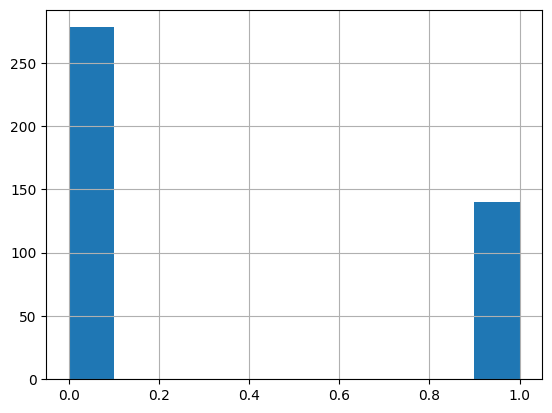

In [22]:
exp_result.submission_df["Survived"].hist()

<Axes: >

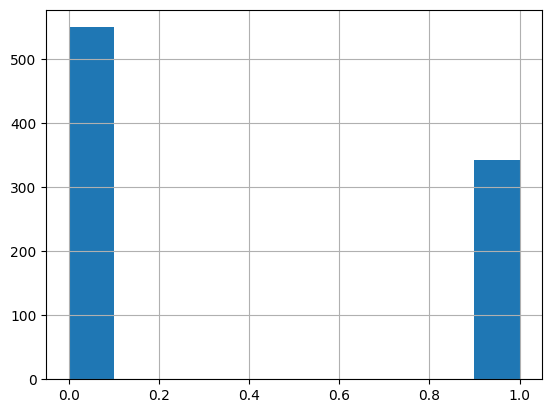

In [23]:
train["Survived"].hist()